In [4]:
import csv
import matplotlib.pyplot as plt
import networkx as nx
import time
import datetime

#%matplotlib notebook

In [3]:
id_class = []
with open("data/original/High-School_data_2013.csv", 'r') as infile:
    reader = csv.reader(infile, delimiter=" ")
    for t, id1, id2, cls1, cls2 in reader:
        id_class.append((int(id1), cls1));
        id_class.append((int(id2), cls2));
id_class.sort(key = lambda x: x[0])

#key is id, value is occurances
id_occurances = {} #dictionary so I can search for keys
for i in id_class:
    if i[0] in id_occurances:
        id_occurances[i[0]] += 1
    else:
        id_occurances[i[0]] = 1
#print(id_occurances)

#key is tuple from id_class, value is occurances
id_class_occurances = {}
for i in id_class:
    if i in id_class_occurances:
        id_class_occurances[i] += 1
    else:
        id_class_occurances[i] = 1

#sort based on id (the first value in the tuple) in id_class_occurances
sorted(id_class_occurances, key = lambda x: x[0])

#write id_class_occurances to a file
# f = open("data/stats/id-class-occurances.txt", "w")
# for key in id_class_occurances.keys():
#     f.write(str(key[0]) + "\t" + str(key[1]) + "\t" + str(id_class_occurances[key]) + "\n")
# f.close()

^^ I ran `sort -n id-class-occurances.txt | cut -f1 |uniq | wc -l` and `sort -n id-class-occurances.txt | cut -f1 | wc -l` in a bash and got 327 for both, so that means that there were no duplicate student IDs, and each student is only ever listed under one class in both the metadata and dynamic contacts.

In [31]:
outside_class_interractions = {}
with open("data/original/High-School_data_2013.csv", 'r') as infile:
    reader = csv.reader(infile, delimiter=" ")
    for t, id1, id2, cls1, cls2 in reader:
        ts = datetime.datetime.fromtimestamp(time.mktime(time.gmtime(int(t) + 3600))) #.strftime("%A, %B %d, %Y %I:%M:%S") #time.strftime("%a %H:%M:%S", time.gmtime(int(t) + 3600))
        if cls1 != cls2:
            if ts in outside_class_interractions:
                outside_class_interractions[ts] += 1
            else:
                outside_class_interractions[ts] = 1


<BarContainer object of 3237 artists>

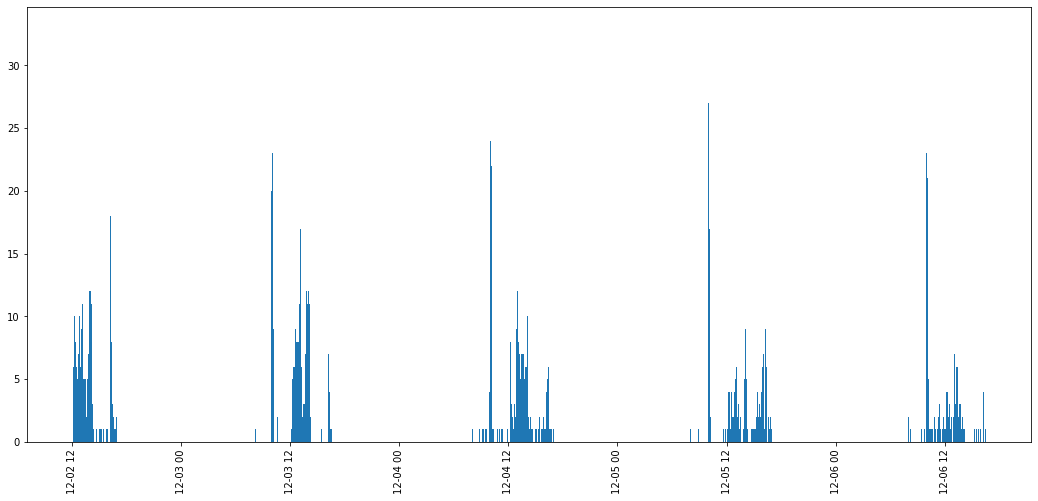

In [38]:
x = list(outside_class_interractions.keys())
y = list(outside_class_interractions.values())
# x1 = []

# i = 0
# for xn in x:
#     if i % 90 == 0:
#         x1.append(xn)
#     else:
#         x1.append(" ")
#     i += 1

f, ax = plt.subplots(figsize=(18,8)) # set the size that you'd like (width, height)
plt.xticks(rotation=90)
plt.bar(x,y, width=0.001)


^^ I want to know **when** people are in contact with people **not** in their class.  Make an x-y graph, x is time, y is count of interractions.

In [ ]:
timestamp_frequency = {}
with open("data/original/High-School_data_2013.csv", 'r') as infile:
    reader = csv.reader(infile, delimiter=" ")
    i = 0
    for t, id1, id2, cls1, cls2 in reader:
        if t in timestamp_frequency:
            timestamp_frequency[t] += 1
        else:
            timestamp_frequency[t] = 1

^^ When in general there is more contact and when there isn't

In [5]:
friendships = [] #list of tuples from friendship data
with open("data/original/Friendship-network_data_2013.csv", 'r') as infile:
    reader = csv.reader(infile, delimiter=" ")
    for id1, id2 in reader:
        friendships.append((int(id1), int(id2)));

mutual_friendships = {} #key is touple of (smaller id, bigger id), value is whether or not it's mutual
for i in friendships:
    isMutual = (i[1], i[0]) in friendships #we know (i[0], i[1]) is already in the list
    friendship_id = (min(i), max(i))
    if not (friendship_id in mutual_friendships): #only adding pair of IDs once, and not when the conjugate is found again
        mutual_friendships[friendship_id] = isMutual
    
#     friendship_id = (min(i), max(i))
#     if (friendship_id in mutual_friendships):
#         mutual_friendships[friendship_id] = True
#     else:
#         mutual_friendships[friendship_id] = False

#write mutual_friendships to a file
# f = open("data/stats/mutual-friendships2.txt", "w")
# for key in mutual_friendships.keys():
#     f.write(str(key[0]) + "\t" + str(key[1]) + "\t" + str(mutual_friendships[key]) + "\n")
# f.close()
print("finished")

finished


^^ I want to know how many of the listed friendships are mutual

In [6]:
G=nx.DiGraph()
Gu = nx.Graph()

for i in friendships:
    G.add_edge(i[0], i[1])
    Gu.add_edge(i[0], i[1])
    Gu.add_edge(i[1], i[0])
    
print("V =",G.number_of_nodes())
print("E =",G.number_of_edges())

cc = nx.clustering(G)
degree = G.degree()
bc = nx.betweenness_centrality(G)

nx.set_node_attributes(G, cc, "clustering_coefficient")
nx.set_node_attributes(G, degree, "degree")
nx.set_node_attributes(G, bc, "betweenness_centrality")
dcent = nx.degree_centrality(G)

V = 134
E = 668


^^ Making the graph and doing calculations

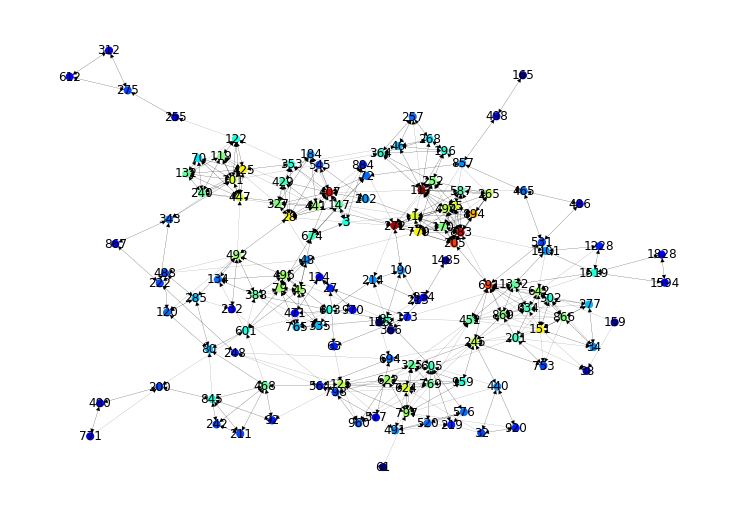

In [11]:
#print(dcent)
mx = dcent[max(dcent.keys(), key=(lambda k: dcent[k]))]
mn = dcent[min(dcent.keys(), key=(lambda k: dcent[k]))]

dcent_color = [plt.cm.jet((dcent[i] - mn)/(mx - mn)) for i in dcent]

bcent = nx.betweenness_centrality(G)
bcent_color = [bcent[i] for i in bcent]

ccent = nx.closeness_centrality(G)
ccent_color = [dcent[i] for i in ccent]


plt.figure(1, figsize=(10, 7))
nx.draw_kamada_kawai(G,with_labels=True,node_size=50,node_color=dcent_color,width=0.1)

plt.show()

^^ Coloring the graph based on degree centrality

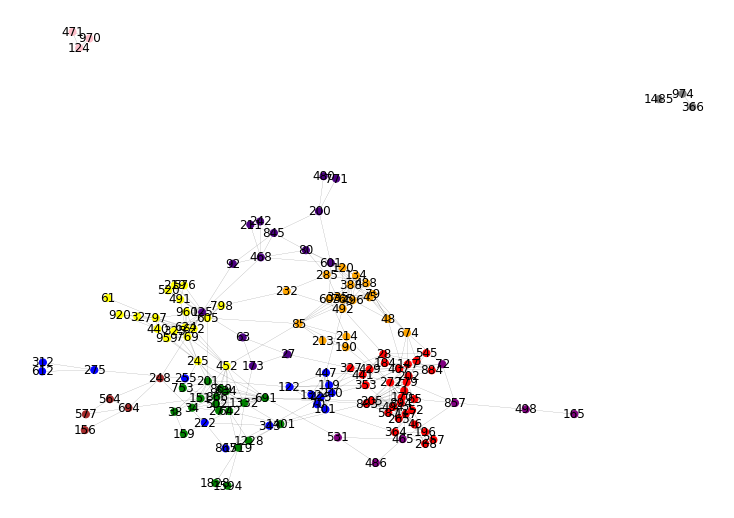

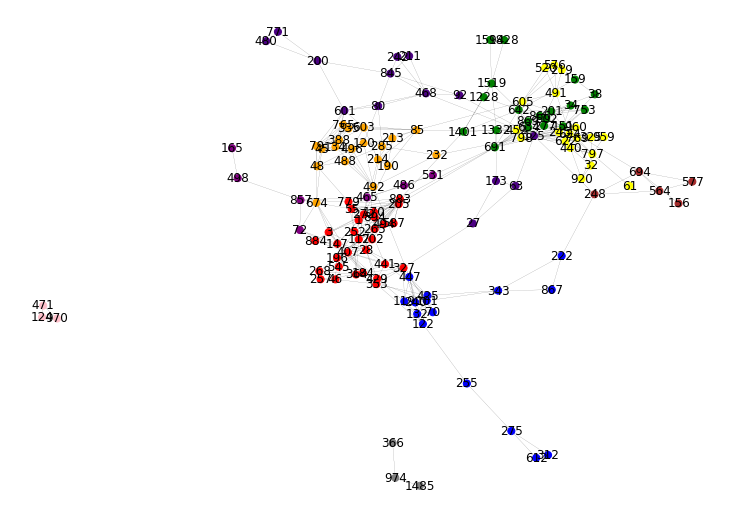

In [25]:
from networkx.algorithms.community import greedy_modularity_communities
c = nx.algorithms.community.greedy_modularity_communities(Gu)
nodes_list = list(Gu.nodes())
community_color = [""] * len(nodes_list)
community_index = 0

for community in c:
    for student in community:
        if community_index == 0:
            community_color[nodes_list.index(student)] = "red"
        elif community_index == 1:
            community_color[nodes_list.index(student)] = "orange"
        elif community_index == 2:
            community_color[nodes_list.index(student)] = "yellow"
        elif community_index == 3:
            community_color[nodes_list.index(student)] = "green"
        elif community_index == 4:
            community_color[nodes_list.index(student)] = "blue"
        elif community_index == 5:
            community_color[nodes_list.index(student)] = "indigo"
        elif community_index == 6:
            community_color[nodes_list.index(student)] = "purple"
        elif community_index == 7:
            community_color[nodes_list.index(student)] = "brown"
        elif community_index == 8:
            community_color[nodes_list.index(student)] = "pink"
        elif community_index == 9:
            community_color[nodes_list.index(student)] = "gray"
    community_index += 1


# plt.figure(1, figsize=(10, 7))
# nx.draw_kamada_kawai(Gu,with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.figure(2, figsize=(10, 7))
pos = nx.drawing.layout.spring_layout(Gu)
nx.draw(Gu, pos, with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.figure(4, figsize=(10, 7))
pos = nx.drawing.layout.spring_layout(Gu, k=2, iterations=800)
nx.draw(Gu, pos, with_labels=True,node_size=50,node_color=community_color,width=0.1)

# plt.figure(3, figsize=(10, 7))
# nx.draw_circular(Gu,with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.show()


^^ Finding communities and coloring nodes

19
[{1485, 974, 366}, {1828, 1228, 173, 1519, 1401, 1594, 27, 63}, {132, 101, 70, 425, 240, 119, 122, 343, 447}, {1, 257, 265, 779, 268, 272, 170, 46, 55, 196, 587, 205, 857, 364, 494, 883, 117, 252, 894}, {970, 124, 471}, {388, 134, 45, 335, 48, 496, 79, 85, 601, 603, 765}, {353, 674, 3, 545, 327, 72, 202, 429, 147, 884, 407, 184, 441, 28}, {34, 866, 452, 642, 38, 869, 201, 753, 691, 1332, 277, 502, 151, 634, 159}, {214, 213, 190}, {498, 165}, {845, 80, 242, 211, 468, 92}, {867, 222}, {488, 232, 492, 120, 285}, {312, 275, 612, 255}, {32, 960, 769, 325, 440, 622, 624, 61, 125, 245, 920, 797, 798, 959}, {465, 531, 486}, {200, 480, 771}, {576, 520, 491, 219, 605}, {577, 564, 694, 248, 156}]


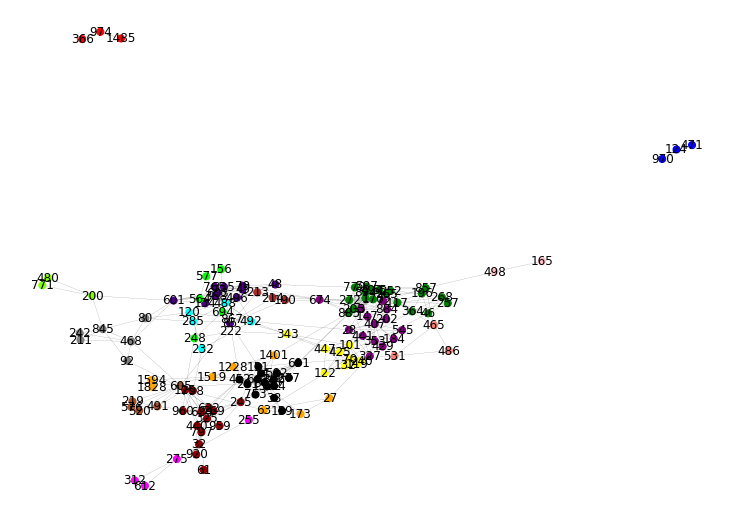

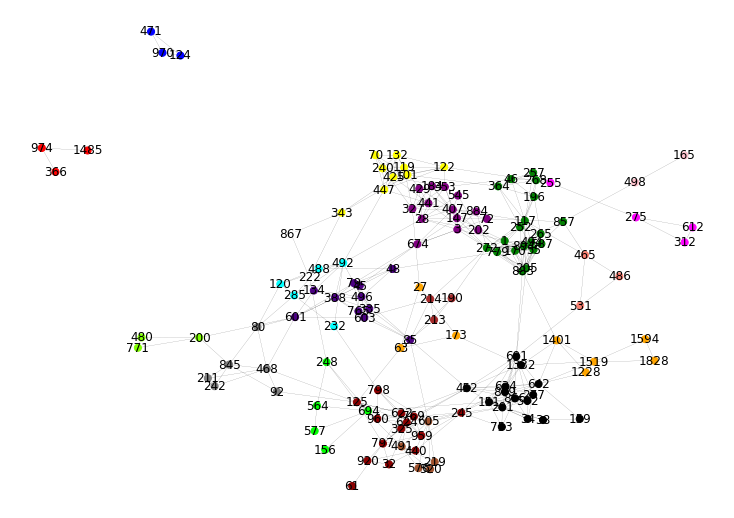

In [30]:
color_list = ["red", "orange", "yellow", "green", "blue", "indigo", "purple", "black", "brown", 
              "pink", "gray", "white", "cyan", "magenta", "darkred", "salmon", "chartreuse", "sienna", "lime"]
c = list(nx.algorithms.community.label_propagation.label_propagation_communities(Gu))
print(len(c))
nodes_list = list(Gu.nodes())
community_color = [""] * len(nodes_list)
community_index = 0
print(c)
for community in c:
    for student in community:
        community_color[nodes_list.index(student)] = color_list[community_index]
    community_index += 1


# plt.figure(1, figsize=(10, 7))
# nx.draw_kamada_kawai(Gu,with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.figure(2, figsize=(10, 7))
pos = nx.drawing.layout.spring_layout(Gu)
nx.draw(Gu, pos, with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.figure(4, figsize=(10, 7))
pos = nx.drawing.layout.spring_layout(Gu, k=2, iterations=800)
nx.draw(Gu, pos, with_labels=True,node_size=50,node_color=community_color,width=0.1)

# plt.figure(3, figsize=(10, 7))
# nx.draw_circular(Gu,with_labels=True,node_size=50,node_color=community_color,width=0.1)

plt.show()
